# SHAP - MultiClass Classification Problem

## Practical example for XAI(Explainable AI) analysis with SHAP for a Multi-class classification problem

* This Example provides a practical understanding on how to use and interpret the open source python package, SHAP, for XAI analysis in Multi-class classification problem and use it to improve the model. 
* Calculating Shapley value to get feature contributions is computational expensive. There are two methods to approximate SHAP values in order to improve computation efficiency: KernelSHAP, TreeSHAP (for tree-based models only). 
* SHAP provides global and local interpretation methods based on aggregations of Shapley values. In this example we will use the Internet Firewall Data Set example from Kaggle datasets , to demonstrate some of the SHAP output plots for a multiclass classification problem.

## Import section

In [20]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, ensemble, model_selection
import numpy as np
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
#! pip install shap
import shap
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [21]:
# load the csv file as a data frame
# source dataset https://www.kaggle.com/datasets/tunguz/internet-firewall-data-set
df = pd.read_csv('/content/drive/MyDrive/deep learning practice/log2.csv')
y = df.Action.copy()
X = df.drop('Action',axis=1)

In [22]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


lets create the model and fit.

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(X_train, y_train)

shap.initjs()

Lets get the random forest feature importance

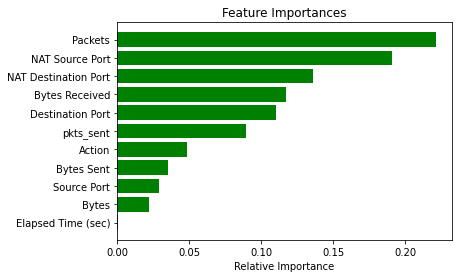

In [24]:
importances = cls.feature_importances_
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Confusion matrix

Confusion matrix is a way to visualize the performance of an model. And more important we can easily see were the model fails exactly.

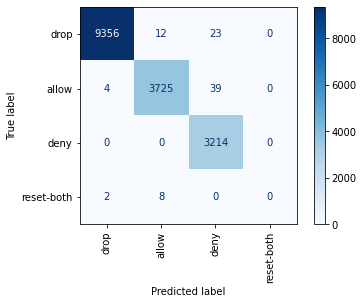

In [25]:
class_names = ['drop', 'allow', 'deny', 'reset-both']
disp = plot_confusion_matrix(cls, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

The model could not detect any instance from the class reset-both. The reason is, unbalanced dataset that gives low number of examples of reset-both class to learn from.

In [26]:
y.value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [27]:
y_test.value_counts()

allow         9391
deny          3768
drop          3214
reset-both      10
Name: Action, dtype: int64

## SHAP Summary Plot

SHAP values of a model’s output explain how features impact the output of the model.

In [28]:
# compute SHAP values
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)

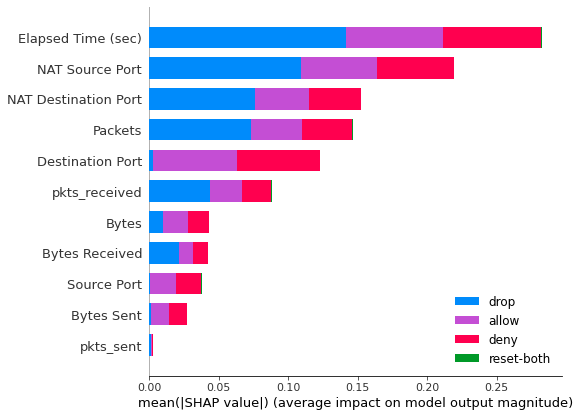

In [29]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

* In this plot the impact of a feature on the classes are stacked to create the feature importance plot. 
* Thus, if you created features in order to differentiate a particular class from the rest, that is the plot were you can see it. 
* In other words summary plot for multiclass classification can show you what the machine managed to learn from the features. 
* In the example below we can see that the class drop hardly uses the features Destination Plot, Source Port and Bytes Sent.
* We can also see the the classes allow and deny uses the same features equally. That is the reason the confusion between them is relatively high. In order to separate better between the allow and deny classes, one needs to generate new features that uniquely be dedicated towards this classes.

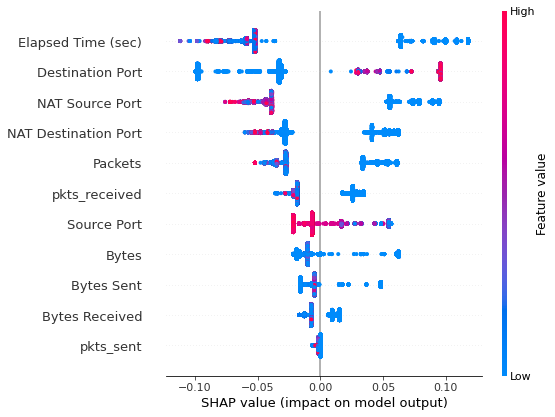

In [33]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

* The summary plot combines feature importance with feature effects. 
* Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. 
* You can see that the feature pkts_sent, being the least important feature, has low Shapley values. The color represents the value of the feature from low to high. 
* Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. 
* The features are ordered according to their importance. In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

## SHAP Dependence Plot

* The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001 ). 
* A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. 
* The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. 
## An assumption of the PDP is that the first feature are not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible. 
* A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.  
* Each dot is a single prediction (row) from the dataset. The x-axis is the actual value from the dataset. The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. 
* The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

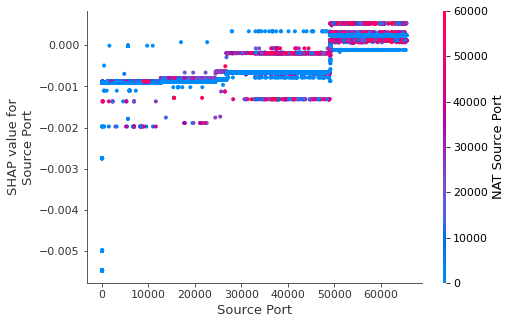

In [34]:
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(0, shap_values[0], X.values, feature_names=X.columns)

# SHAP Force plot

Force plot gives us the explainability of a single model prediction. In this plot we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or for a deep understanding of a particular case.

In [36]:
i=8
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns)

* From the plot we can see: The model predict_proba value: 0.79 The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over training datatset (explainer.expected_value in the code). 
* In this example base value = 0.5749 The numbers on the plot arrows are the value of the feature for this instance. 
* Elapsed Time (sec)=5 and Packets = 1 Red representing features that pushed the model score higher, and blue representing features that pushed the score lower. 
* The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen in the x axis. Elapsed Time of 5 seconds increases the property that the class is allow, Packets of 1 reduces the property value.



## SHAP waterfall plot

Waterfall is another local analysis plot of a single instance prediction. Let’s take instance number 8 as an example:

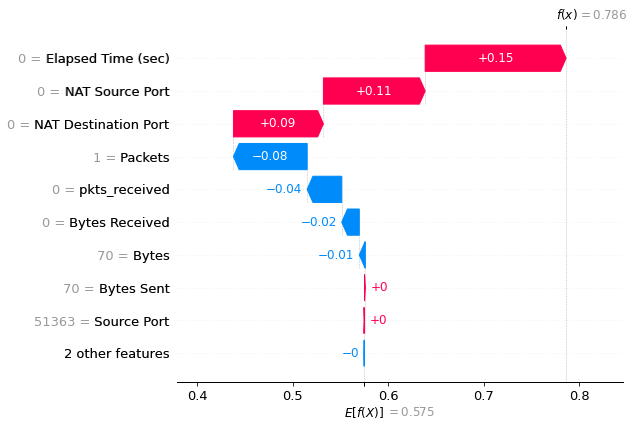

In [37]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                        base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                        feature_names=X_test.columns.tolist()))

f(x) is the model predict_proba value: 0.786. E[f(x)] is the base value = 0.575. On the left are the features value and on the arrows the feature contribution to the prediction. Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction .

## Summary

The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation. SHAP combines several existing methods to create an intuitive, theoretically sound approach to explain predictions for any model. SHAP values quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction. I believe XAI analysis with SHAP and other tools should be an integral part of the machine learning pipeline.